In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/my-data/Full Final.csv


In [32]:
# Install imblearn (for SMOTE) if not already installed
!pip install -q imbalanced-learn

# 1.1: Load the dataset from the Kaggle input folder
import pandas as pd, numpy as np
data_path = "/kaggle/input/my-data/Full Final.csv"  # use your actual dataset name here
df = pd.read_csv(data_path)

# 1.2: Keep only the relevant columns
df = df[["Temp_C", "Temp_F", "SpO2", "BPM", "Anomaly"]]

# 1.3: Inspect the first few rows and basic info
print("First 5 rows:")
print(df.head(5))
print("\nDataFrame Info:")
df.info()


First 5 rows:
  Temp_C Temp_F  SpO2   BPM   Anomaly
0  33.86  92.95  97.0  51.0  Abnormal
1  33.86  92.95  97.0  72.0    Normal
2  33.86  92.95  97.0  72.0    Normal
3  33.92  93.06  97.0  72.0    Normal
4  33.92  93.06  98.0  72.0    Normal

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6696 entries, 0 to 6695
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Temp_C   6696 non-null   object 
 1   Temp_F   6696 non-null   object 
 2   SpO2     6513 non-null   float64
 3   BPM      6690 non-null   float64
 4   Anomaly  6696 non-null   object 
dtypes: float64(2), object(3)
memory usage: 261.7+ KB


In [33]:
# Basic descriptive statistics for all columns
print(df.describe(include="all"))


       Temp_C Temp_F         SpO2          BPM   Anomaly
count    6696   6696  6513.000000  6690.000000      6696
unique    194    194          NaN          NaN         2
top     36.36  97.45          NaN          NaN  Abnormal
freq      338    338          NaN          NaN      4546
mean      NaN    NaN    93.586571    66.049925       NaN
std       NaN    NaN     6.876629    16.338965       NaN
min       NaN    NaN     0.840000    26.000000       NaN
25%       NaN    NaN    91.000000    55.000000       NaN
50%       NaN    NaN    96.000000    67.000000       NaN
75%       NaN    NaN    98.000000    76.000000       NaN
max       NaN    NaN   101.000000   121.000000       NaN


2. Data Hygiene & Preprocessing

In [34]:
# 2.1: Convert temperature strings to numeric by stripping non-numeric characters
# (Remove any unit symbols like "°C" or "°F")
df["Temp_C"] = df["Temp_C"].astype(str).str.replace(r"[^0-9\.\+\-]", "", regex=True)
df["Temp_F"] = df["Temp_F"].astype(str).str.replace(r"[^0-9\.\+\-]", "", regex=True)

# Convert to float (coerce errors to NaN if any non-numeric remains)
df["Temp_C"] = pd.to_numeric(df["Temp_C"], errors="coerce")
df["Temp_F"] = pd.to_numeric(df["Temp_F"], errors="coerce")

# 2.2: Ensure SpO2 and BPM are numeric (coerce any unexpected strings to NaN)
df["SpO2"] = pd.to_numeric(df["SpO2"], errors="coerce")
df["BPM"]  = pd.to_numeric(df["BPM"], errors="coerce")

# 2.3: Check total missing values per column after conversion
print("Missing values after conversion:")
print(df.isna().sum())

# 2.4: Identify and drop duplicate rows
dup_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {dup_count}")
if dup_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates dropped. New shape: {df.shape}")

# 2.5: Outlier handling for SpO2
# Cap SpO2 > 100 to 100
above_100 = df["SpO2"] > 100
if above_100.any():
    count_cap = above_100.sum()
    df.loc[above_100, "SpO2"] = 100.0
    print(f"Capped {count_cap} SpO2 values above 100 to 100.")

# Remove rows where SpO2 < 50 (sensor error outliers)
sp_outliers = df[(df["SpO2"] < 50) & (~df["SpO2"].isna())]
outlier_count = sp_outliers.shape[0]
if outlier_count > 0:
    df.drop(index=sp_outliers.index, inplace=True)
    print(f"Removed {outlier_count} rows with SpO2 < 50 as outliers.")

# 2.6: Missing value imputation (median by class)
print(f"\nMissing values before imputation:\n{df[['SpO2','BPM']].isna().sum()}")

# Fill SpO2 and BPM missing values with class-specific medians
for col in ["SpO2", "BPM"]:
    class_medians = df.groupby("Anomaly")[col].transform("median")
    df[col] = df[col].fillna(class_medians)

# If any remaining missing (e.g., if a class had all values missing), fill with overall median
df["SpO2"].fillna(df["SpO2"].median(), inplace=True)
df["BPM"].fillna(df["BPM"].median(), inplace=True)

print(f"\nMissing values after imputation:\n{df[['SpO2','BPM']].isna().sum()}")

# 2.7: Final sanity check of data types and structure
print("\nDataFrame Info after cleaning:")
df.info()


Missing values after conversion:
Temp_C       0
Temp_F       0
SpO2       183
BPM          6
Anomaly      0
dtype: int64

Number of duplicate rows: 2773
Duplicates dropped. New shape: (3923, 5)
Capped 1 SpO2 values above 100 to 100.
Removed 7 rows with SpO2 < 50 as outliers.

Missing values before imputation:
SpO2    46
BPM      6
dtype: int64

Missing values after imputation:
SpO2    0
BPM     0
dtype: int64

DataFrame Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 3916 entries, 0 to 6497
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Temp_C   3916 non-null   float64
 1   Temp_F   3916 non-null   float64
 2   SpO2     3916 non-null   float64
 3   BPM      3916 non-null   float64
 4   Anomaly  3916 non-null   object 
dtypes: float64(4), object(1)
memory usage: 183.6+ KB


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




3. Class Distribution & Basic Plots

Class counts:
 {'Abnormal': 2627, 'Normal': 1289}


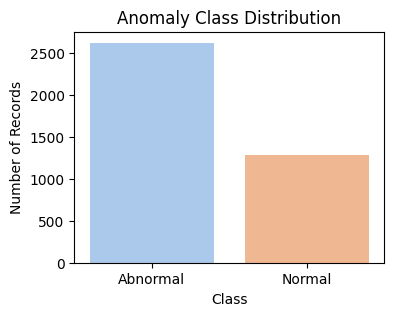

In [35]:
# 3.1: Plot class distribution (Normal vs Abnormal counts)
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each class
class_counts = df["Anomaly"].value_counts()
print("Class counts:\n", class_counts.to_dict())

plt.figure(figsize=(4,3))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="pastel")
plt.title("Anomaly Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Records")
plt.show()


Correlation matrix:
         Temp_C  Temp_F   SpO2    BPM
Temp_C   1.000   1.000 -0.043  0.014
Temp_F   1.000   1.000 -0.043  0.014
SpO2    -0.043  -0.043  1.000  0.275
BPM      0.014   0.014  0.275  1.000


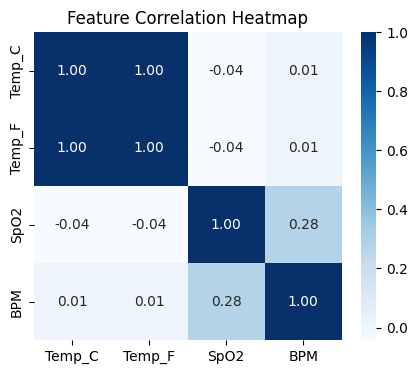

In [36]:
# 3.2: Compute correlation matrix for numeric features and plot heatmap
corr_matrix = df[["Temp_C", "Temp_F", "SpO2", "BPM"]].corr()
print("Correlation matrix:\n", corr_matrix.round(3))

plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues", square=True,
            xticklabels=["Temp_C","Temp_F","SpO2","BPM"],
            yticklabels=["Temp_C","Temp_F","SpO2","BPM"])
plt.title("Feature Correlation Heatmap")
plt.show()


4. Train–Test Split & SMOTE

In [37]:
# 4.1: Encode target labels to numeric values
label_mapping = {"Normal": 0, "Abnormal": 1}
df["Anomaly_Code"] = df["Anomaly"].map(label_mapping)
print("Encoding mapping for Anomaly:", label_mapping)

# 4.2: Define features and target
# feature_cols = ["Temp_C", "Temp_F", "SpO2", "BPM"]
feature_cols = ["Temp_C", "SpO2", "BPM"]

X = df[feature_cols]
y = df["Anomaly_Code"]

# 4.3: Split data into training and test sets (80/20 split, stratified by class)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"\nTrain set size: {X_train.shape[0]}  (Class distribution: {np.bincount(y_train)})")
print(f"Test set size:  {X_test.shape[0]}  (Class distribution: {np.bincount(y_test)})")

# 4.4: Use SMOTE to oversample the minority class in the training set
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("\nTraining set class distribution before SMOTE:", np.bincount(y_train))
print("Training set class distribution after SMOTE:", np.bincount(y_train_res))


Encoding mapping for Anomaly: {'Normal': 0, 'Abnormal': 1}

Train set size: 3132  (Class distribution: [1031 2101])
Test set size:  784  (Class distribution: [258 526])

Training set class distribution before SMOTE: [1031 2101]
Training set class distribution after SMOTE: [2101 2101]


5. Model Training, Cross-Validation, and Evaluation

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 5.1: Set up models and pipelines (scaling for Logistic Regression)
lr_pipeline = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=1000, random_state=42))])
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

models = [("Logistic Regression", lr_pipeline),
          ("Random Forest", rf_model),
          ("Gradient Boosting", gb_model)]

# 5.2: Cross-validation for each model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["accuracy", "f1_macro", "roc_auc"]
results = {}

for name, model in models:
    cv_scores = cross_validate(model, X_train_res, y_train_res, cv=cv, scoring=scoring)
    results[name] = {
        "Accuracy Mean": cv_scores["test_accuracy"].mean(),
        "Accuracy Std": cv_scores["test_accuracy"].std(),
        "F1_mean": cv_scores["test_f1_macro"].mean(),
        "F1_std": cv_scores["test_f1_macro"].std(),
        "ROC_mean": cv_scores["test_roc_auc"].mean(),
        "ROC_std": cv_scores["test_roc_auc"].std()
    }

# Print cross-validation results
print("Model Performance (5-fold CV):")
for name, res in results.items():
    print(f"{name:18}: Accuracy = {res['Accuracy Mean']:.3f} ± {res['Accuracy Std']:.3f}, "
          f"F1 = {res['F1_mean']:.3f} ± {res['F1_std']:.3f}, ROC-AUC = {res['ROC_mean']:.3f} ± {res['ROC_std']:.3f}")


Model Performance (5-fold CV):
Logistic Regression: Accuracy = 0.792 ± 0.021, F1 = 0.792 ± 0.022, ROC-AUC = 0.844 ± 0.017
Random Forest     : Accuracy = 0.955 ± 0.009, F1 = 0.955 ± 0.009, ROC-AUC = 0.992 ± 0.002
Gradient Boosting : Accuracy = 0.946 ± 0.010, F1 = 0.946 ± 0.010, ROC-AUC = 0.989 ± 0.002


Test Set Performance:
              precision    recall  f1-score   support

      Normal       0.92      0.92      0.92       258
    Abnormal       0.96      0.96      0.96       526

    accuracy                           0.95       784
   macro avg       0.94      0.94      0.94       784
weighted avg       0.95      0.95      0.95       784

Confusion Matrix (Actual vs Predicted):
                 Predicted Normal  Predicted Abnormal
Actual Normal                 237                  21
Actual Abnormal                20                 506
Test ROC-AUC: 0.987


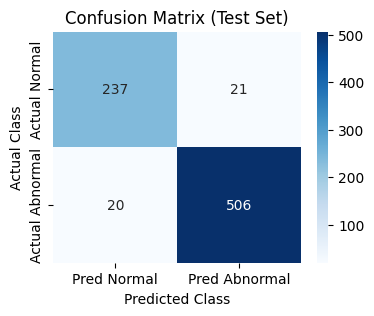

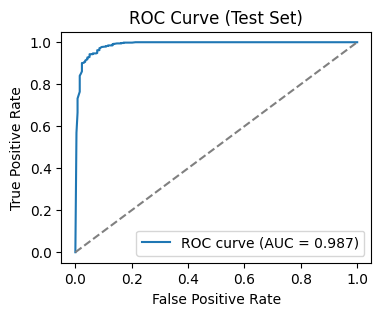

In [39]:
# 5.3: Train the best model (Random Forest) on the full SMOTE-balanced training set
best_model_name = "Random Forest"
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train_res, y_train_res)

# 5.4: Evaluate on the test set
# Predict class labels and class probabilities
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Test Set Performance:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Abnormal"]))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Actual vs Predicted):")
print(pd.DataFrame(cm, index=["Actual Normal", "Actual Abnormal"], 
                   columns=["Predicted Normal", "Predicted Abnormal"]))

# Compute ROC-AUC on test set
test_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC-AUC: {test_auc:.3f}")

# Plot confusion matrix as heatmap
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Normal","Pred Abnormal"],
            yticklabels=["Actual Normal","Actual Abnormal"])
plt.title("Confusion Matrix (Test Set)")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# Plot ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {test_auc:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.show()


6. Model Interpretation & Journal-Ready Notes

Temp_C: 0.2917
SpO2: 0.2993
BPM: 0.4091


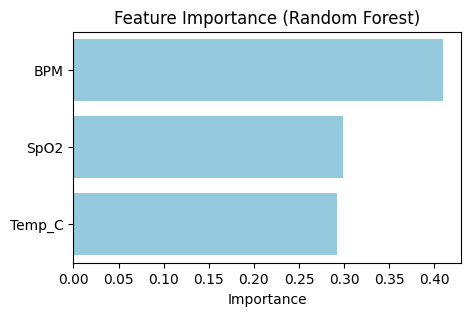

In [40]:
# Feature Importance for Random Forest
feature_names = feature_cols  # ["Temp_C", "Temp_F", "SpO2", "BPM"]
importances = best_model.feature_importances_
for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.4f}")
# Plotting feature importance
imp_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(5,3))
sns.barplot(x=imp_series.values, y=imp_series.index, color="skyblue")
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()


7. Final Outputs

In [41]:
# # Save the cleaned and preprocessed dataset
# # (Anomaly is kept as string label for clarity; features are numeric.)
# refined_df = df[["Temp_C", "Temp_F", "SpO2", "BPM", "Anomaly"]].copy()
# refined_df.to_csv("Refined_Dataset_for_ML.csv", index=False)
# print("Refined dataset saved. Shape:", refined_df.shape)


In [42]:
df = df.drop(columns=["Temp_F"])
feature_cols = ["Temp_C", "SpO2", "BPM"]

In [43]:
# STEP 1 — SAFE HYPERPARAMETER TUNING (Kaggle Cell)
from sklearn.model_selection import GridSearchCV

# ---- Random Forest Tuning ----
rf = RandomForestClassifier(random_state=42)

rf_params = {
    "n_estimators": [200, 400],
    "max_depth": [5, 10, None],
    "min_samples_leaf": [1, 5, 10]
}

rf_grid = GridSearchCV(
    rf,
    rf_params,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

rf_grid.fit(X_train_res, y_train_res)

best_rf = rf_grid.best_estimator_
print("Best Random Forest:", rf_grid.best_params_)


# ---- Gradient Boosting Tuning ----
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)

gb_params = {
    "n_estimators": [200, 300],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5]
}

gb_grid = GridSearchCV(
    gb,
    gb_params,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

gb_grid.fit(X_train_res, y_train_res)

best_gb = gb_grid.best_estimator_
print("Best Gradient Boosting:", gb_grid.best_params_)


Best Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 400}
Best Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}


In [44]:
#🔹 STEP 2 — Logistic Regression (Calibrated, Scaled)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
])

log_model.fit(X_train_res, y_train_res)


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [45]:
#STEP 3 — PROPOSED ENSEMBLE MODEL
from sklearn.ensemble import VotingClassifier

proposed_model = VotingClassifier(
    estimators=[
        ("rf", best_rf),
        ("gb", best_gb),
        ("lr", log_model)
    ],
    voting="soft"
)

proposed_model.fit(X_train_res, y_train_res)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=400,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=5,
                                                         n_estimators=300,
                                                         random_state=42)),
                             ('lr',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('clf',
                                               LogisticRegression(class_weight='balanced',
                                                                  max_iter=1000))]))],
                 voting='soft')

In [46]:
#🔹 STEP 4 — FINAL TEST EVALUATION OF PROPOSED MODEL
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = proposed_model.predict(X_test)
y_proba = proposed_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

test_auc = roc_auc_score(y_test, y_proba)
print("Test ROC-AUC:", test_auc)


              precision    recall  f1-score   support

           0       0.92      0.93      0.93       258
           1       0.97      0.96      0.96       526

    accuracy                           0.95       784
   macro avg       0.95      0.95      0.95       784
weighted avg       0.95      0.95      0.95       784

Confusion Matrix:
 [[241  17]
 [ 20 506]]
Test ROC-AUC: 0.9909069472691366


In [47]:
#STEP 5 — OPTIONAL: CLINICAL SAFETY THRESHOLD (RECOMMENDED)
custom_threshold = 0.45
y_pred_custom = (y_proba >= custom_threshold).astype(int)

print(classification_report(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.94      0.91      0.93       258
           1       0.96      0.97      0.96       526

    accuracy                           0.95       784
   macro avg       0.95      0.94      0.94       784
weighted avg       0.95      0.95      0.95       784



In [48]:
#2. Wrap your chosen threshold in a helper function
# Choose your final model and threshold
final_model = proposed_model      # or best_rf if you decided that is final
decision_threshold = 0.45         # change if you picked another

def predict_with_threshold(model, X, threshold=decision_threshold):
    proba = model.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

# Re-evaluate once with this function (for clarity)
y_pred_final = predict_with_threshold(final_model, X_test, decision_threshold)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Final model with chosen threshold:")
print(classification_report(y_test, y_pred_final))

cm_final = confusion_matrix(y_test, y_pred_final)
print("Confusion matrix:\n", cm_final)

# AUC stays based on probabilities
y_proba_final = final_model.predict_proba(X_test)[:, 1]
auc_final = roc_auc_score(y_test, y_proba_final)
print("Final ROC-AUC:", auc_final)


Final model with chosen threshold:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       258
           1       0.96      0.97      0.96       526

    accuracy                           0.95       784
   macro avg       0.95      0.94      0.94       784
weighted avg       0.95      0.95      0.95       784

Confusion matrix:
 [[235  23]
 [ 15 511]]
Final ROC-AUC: 0.9909069472691366


In [49]:
#3. Save the final model (and remember the threshold)
import joblib

# Save final proposed model
joblib.dump(final_model, "proposed_model.joblib")

print("Saved proposed_model.joblib")

# Example prediction using the same threshold
loaded_model = joblib.load("proposed_model.joblib")

# Use only the features used in training: Temp_C, SpO2, BPM
new_sample = pd.DataFrame(
    [[37.0, 99, 70]],   # Temp_C, SpO2, BPM
    columns=["Temp_C", "SpO2", "BPM"]
)

def predict_safe(model, X, threshold=decision_threshold):
    proba = model.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

pred_class = predict_safe(loaded_model, new_sample)[0]
label = "Abnormal" if pred_class == 1 else "Normal"

print("New sample:", new_sample.to_dict(orient="records")[0])
print("Model prediction with threshold", decision_threshold, ":", label)



Saved proposed_model.joblib
New sample: {'Temp_C': 37.0, 'SpO2': 99, 'BPM': 70}
Model prediction with threshold 0.45 : Normal


In [50]:
# 8. Model Explainability with SHAP

!pip install -q shap

import shap

# For interactive plots in notebook
shap.initjs()


In [51]:
# Use the tuned Random Forest as main explainer model
explainer = shap.TreeExplainer(best_rf)

# Use the SMOTE-balanced training data for SHAP
X_shap = X_train_res.copy()

# For binary classification, shap_values is a list: [class 0, class 1]
shap_values = explainer.shap_values(X_shap)

print("Number of classes in SHAP values:", len(shap_values))
print("Shape of SHAP values for class 1:", shap_values[1].shape)


Number of classes in SHAP values: 2
Shape of SHAP values for class 1: (4202, 3)


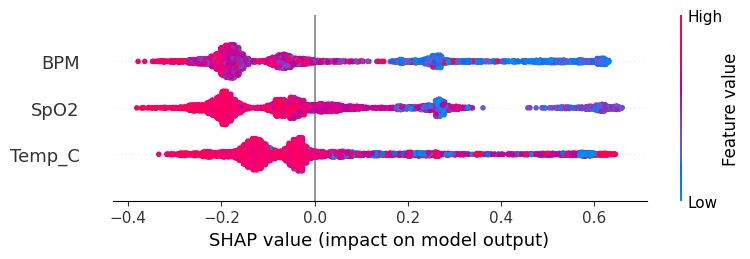

In [52]:
# Global summary for Abnormal class (class 1)
feature_names = X_shap.columns

shap.summary_plot(
    shap_values[1],   # SHAP values for class 1 (Abnormal)
    X_shap,
    feature_names=feature_names
)


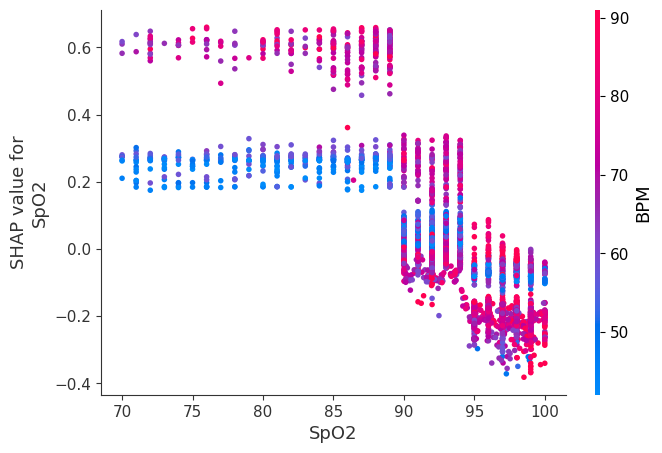

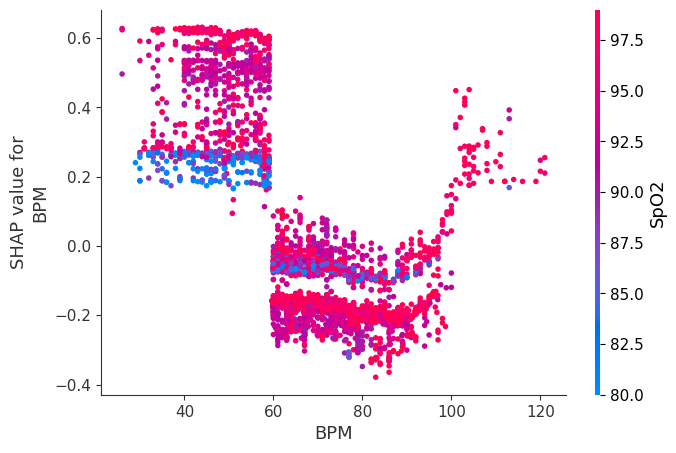

In [53]:
# How SpO2 affects prediction for Abnormal
shap.dependence_plot(
    "SpO2",
    shap_values[1],
    X_shap,
    feature_names=feature_names
)

# How BPM affects prediction for Abnormal
shap.dependence_plot(
    "BPM",
    shap_values[1],
    X_shap,
    feature_names=feature_names
)


In [54]:
# Pick one sample from test set (for example, index 0)
idx = 0
x_sample = X_test.iloc[[idx]]
y_true = y_test.iloc[idx]

print("True label (0 = Normal, 1 = Abnormal):", y_true)
display(x_sample)

# SHAP values for this one sample
sample_shap_values = explainer.shap_values(x_sample)

# Force plot: shows which features pushed towards Abnormal
shap.force_plot(
    explainer.expected_value[1],
    sample_shap_values[1],
    x_sample
)


True label (0 = Normal, 1 = Abnormal): 0


,Temp_C,SpO2,BPM
5868,36.86,97.0,78.0


In [55]:
# Install and import imblearn for pipeline with SMOTE
!pip install -q imbalanced-learn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# Define base classifiers (assuming they've been tuned previously)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
rf = RandomForestClassifier(n_estimators=400, random_state=42)
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
lr = LogisticRegression(max_iter=1000, solver='lbfgs')  # logistic (we'll handle scaling separately)

# For logistic regression, include scaling in its pipeline
from sklearn.preprocessing import StandardScaler
lr_pipeline = Pipeline([('scaler', StandardScaler()), ('lr', lr)])

# Combine in a VotingClassifier (soft voting)
ensemble = VotingClassifier(estimators=[('rf', rf), ('gb', gb), ('lr', lr_pipeline)], voting='soft')

# Pipeline: SMOTE -> Ensemble Model
model_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)), 
    ('classifier', ensemble)
])

# Perform stratified 5-fold cross-validation with pipeline
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1', 'roc_auc']
cv_results = cross_validate(model_pipeline, X_train, y_train, cv=cv, scoring=scoring)

print("CV Accuracy: %.3f ± %.2f" % (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()))
print("CV F1-score: %.3f ± %.2f" % (cv_results['test_f1'].mean(), cv_results['test_f1'].std()))
print("CV ROC-AUC: %.3f ± %.2f" % (cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std()))


CV Accuracy: 0.942 ± 0.01
CV F1-score: 0.956 ± 0.01
CV ROC-AUC: 0.985 ± 0.01


In [56]:
from sklearn.calibration import CalibratedClassifierCV

# Use the correct parameter 'estimator' instead of 'base_estimator'
calibrated_ensemble = CalibratedClassifierCV(estimator=ensemble, cv=5, method='sigmoid')
calibrated_ensemble.fit(X_train, y_train)

# Predict calibrated probabilities on test set
y_proba = calibrated_ensemble.predict_proba(X_test)[:, 1]
y_pred_05 = (y_proba >= 0.5).astype(int)

# Evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
print("Test Accuracy: %.3f" % accuracy_score(y_test, y_pred_05))
print("Test F1-score (Abnormal): %.3f" % f1_score(y_test, y_pred_05, pos_label=1))
print("Test Precision (Abnormal): %.3f" % precision_score(y_test, y_pred_05, pos_label=1))
print("Test Recall (Abnormal): %.3f" % recall_score(y_test, y_pred_05, pos_label=1))
print("Test ROC-AUC: %.3f" % roc_auc_score(y_test, y_proba))

# Threshold tuning
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = f1_scores[:-1].argmax()
best_thresh = thresholds[best_idx]
print("Best F1 %.3f at threshold = %.2f" % (f1_scores[best_idx], best_thresh))

adjusted_thresh = best_thresh
y_pred_adj = (y_proba >= adjusted_thresh).astype(int)
print("Adjusted Threshold=%.2f -> Precision: %.3f, Recall: %.3f, F1: %.3f" % 
      (adjusted_thresh,
       precision_score(y_test, y_pred_adj, pos_label=1),
       recall_score(y_test, y_pred_adj, pos_label=1),
       f1_score(y_test, y_pred_adj, pos_label=1)))


Test Accuracy: 0.958
Test F1-score (Abnormal): 0.969
Test Precision (Abnormal): 0.957
Test Recall (Abnormal): 0.981
Test ROC-AUC: 0.991
Best F1 0.976 at threshold = 0.36
Adjusted Threshold=0.36 -> Precision: 0.956, Recall: 0.996, F1: 0.976


In [57]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

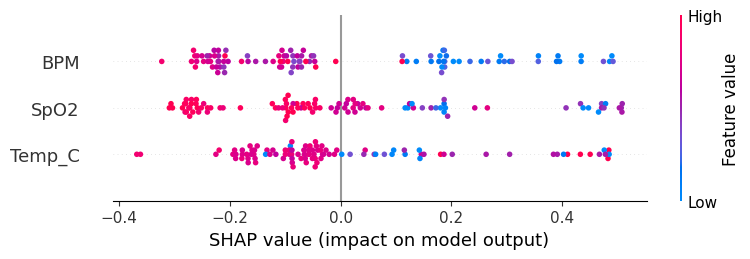

In [58]:
import shap

# Confirm that rf was trained earlier; if not, train it again:
# rf.fit(X_train, y_train)  ← Uncomment only if not already trained

# Use TreeExplainer for the raw fitted model
explainer = shap.TreeExplainer(rf)

# Use a small sample from X_test
X_sample = X_test[:100]

# Compute SHAP values for classification (returns list of arrays per class)
shap_values = explainer.shap_values(X_sample)

# SHAP summary plot for class 1 ("Abnormal")
shap.summary_plot(shap_values[1], X_sample, feature_names=X_sample.columns.tolist())


In [59]:
#4. Optional: Stacking Ensemble & Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__rf__max_depth': [None, 5, 10], 
    'classifier__rf__min_samples_leaf': [1, 3, 5]
}
grid = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best CV F1-score: %.3f" % grid.best_score_)
best_model = grid.best_estimator_


Best parameters: {'classifier__rf__max_depth': None, 'classifier__rf__min_samples_leaf': 1}
Best CV F1-score: 0.959


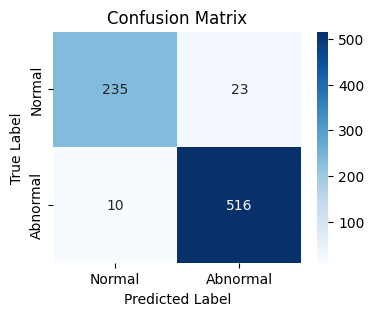

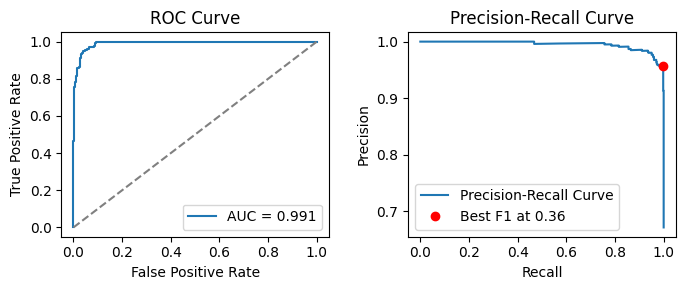

In [60]:
#5. Evaluation of Improvements
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred_05)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Normal','Abnormal'], yticklabels=['Normal','Abnormal'])
plt.xlabel("Predicted Label"); plt.ylabel("True Label"); plt.title("Confusion Matrix")
plt.show()

# ROC and Precision-Recall Curves
fpr, tpr, _ = roc_curve(y_test, y_proba)
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label="AUC = %.3f" % roc_auc_score(y_test, y_proba))
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.subplot(1,2,2)
plt.plot(rec, prec, label="Precision-Recall Curve")
# Mark best F1 point:
best_id = best_idx
plt.plot(rec[best_id], prec[best_id], 'ro', label="Best F1 at %.2f" % best_thresh)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


## 🚀 Export Model for Django API

In [ ]:
# Save the model to Django project directory
import joblib
import os

# Django project path
django_project_path = r"d:\Django ApI\newproject"

# Make sure the directory exists
os.makedirs(django_project_path, exist_ok=True)

# Save the model
model_save_path = os.path.join(django_project_path, "proposed_model.joblib")

# Use the final_model or proposed_model from your notebook
# If you haven't run the cells above, you'll need to run them first
try:
    joblib.dump(proposed_model, model_save_path)
    print(f"✅ Model successfully saved to: {model_save_path}")
    print(f"File size: {os.path.getsize(model_save_path) / (1024*1024):.2f} MB")
except NameError:
    print("❌ Error: 'proposed_model' not found. Please run the model training cells first!")
    print("   Specifically, run the cells that create 'proposed_model' or 'final_model'")